In [3]:
import sys
sys.path.insert(0, './pyged/lib')
import pyged

import torch 
import numpy as np
import matplotlib.pyplot as plt

from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.transforms import RemoveDuplicatedEdges
from torch_geometric.utils import subgraph, to_networkx, from_networkx
from multiprocessing import Pool, cpu_count
import torch.multiprocessing as mp
mp.set_sharing_strategy('file_system')
from time import time

from data.distances.OCTADataset import OCTADataset
from data.distances.CitiesDataset import CitiesDataset
from data.visualize_sample import draw_graph

In [39]:
def remove_reverse_edges(edge_index):
    pairs_tensor = torch.stack((edge_index[0], edge_index[1]), dim=1)
    l = pairs_tensor.tolist()
    l = list({*map(tuple, map(sorted, l))})
    print("l", l)
    l_filtered = [edge for edge in l if edge[0] != edge[1]]
    print("l_filtered", l_filtered)
    return torch.tensor(list(zip(*l_filtered)))

def random_bfs_sample(g, n_hops, trav_prob):
    try:
        G = to_networkx(g, node_attrs=["pos", "x"]).to_undirected()
        components = [G.subgraph(c).copy() for c in nx.connected_components(G)]

        e = []
        n = []
        p = []
        for component in components: 
            comp = from_networkx(component)

            e_c, n_c, p_c = random_bfs_edge_index(comp, n_hops, trav_prob)
            e.append(e_c)
            n.append(n_c)
            p.append(p_c)

        acc_len = 0
        e_multiplied = []
        for i, e_i in enumerate(e):
            if i!=0:
                e_i += acc_len
            e_multiplied.append(e_i)
            acc_len += len(n[i] - 1)

        x = torch.cat(n, dim=0)
        p = torch.cat(p, dim=0)
        e_multiplied = torch.cat(e_multiplied, dim=1) 

        e_unique = remove_reverse_edges(e_multiplied)
    except Exception as e:
        print(e)
        print(g)

    return Data(x=x, pos=p, edge_index=e_unique)

def random_bfs_edge_index(g, n_hops, trav_prob):
    front_mask = torch.zeros(g.num_nodes, dtype=torch.bool)
    start_idx = torch.randint(0, g.num_nodes, (1, 1))
    front_mask[start_idx] = True
    seen_node_mask = torch.zeros(g.num_nodes, dtype=torch.bool)
    seen_node_mask[start_idx] = True
    seen_edge_mask = torch.zeros(g.num_edges, dtype=torch.bool)

    for _ in range(n_hops):
        random_mask = torch.rand(g.num_edges) <= trav_prob
        edge_mask = front_mask[g.edge_index[0]] & random_mask
        seen_edge_mask |= edge_mask  
        front_mask.fill_(False)
        front_mask[g.edge_index[1, edge_mask]] = True 
        front_mask &= ~seen_node_mask
        seen_node_mask |= front_mask 

    new_x = g.x[seen_node_mask]
    new_pos = g.pos[seen_node_mask]
    new_index = torch.empty(g.num_nodes, dtype=torch.long)
    new_index[seen_node_mask] = torch.arange(torch.sum(seen_node_mask))
    new_edge_index = new_index[g.edge_index[:, seen_edge_mask]]
    new_edge_index = torch.unique(torch.cat((new_edge_index, new_edge_index[[1,0],:]), dim=1), dim=1)
    return new_edge_index, new_x, new_pos


def sample_subgraph(graph, perturb_ratio=0.5, n_hops=7, trav_prob=0.7, radius=0.02):
    query = random_bfs_sample(graph, n_hops, trav_prob)
    query = perturb_pos(query, perturb_ratio, radius)
    query = add_random(query, perturb_ratio)
    
    return query, graph


def perturb_pos(query, perturb_ratio, radius):
    perturb = torch.rand((1, 1)) <= perturb_ratio
    if perturb:
        print('shift')
        shift = torch.rand(query.pos.size()) * 2 * radius - radius
        new_position = query.pos + shift
        print(query.pos - new_position)
        query.pos = new_position
    return query

def add_random(query, perturb_ratio):
    if 0 <= perturb_ratio >= 1.0:
        print("Perturb ratio should be between 0 and 1. Ignoring operation")
        return query
    
    perturb_edges = torch.rand((1, 1)) <= perturb_ratio
    if perturb_edges:
        print('add edges')
        num_edges = max(1, int(perturb_ratio * query.num_edges))

        new_edges_to_add = torch.randint(0, query.num_nodes, (2, num_edges), dtype=torch.int)
        new_edge_index = torch.cat((query.edge_index, new_edges_to_add), dim=1)
        query.edge_index = new_edge_index

        transform = RemoveDuplicatedEdges()
        query = transform(query)

        query.edge_index = remove_reverse_edges(query.edge_index)
        
    perturb_nodes = torch.rand((1, 1)) <= perturb_ratio
    if perturb_nodes:
        print('add nodes')
        num_nodes = torch.randint(0, query.num_nodes, (1, 1))
        new_nodes_pos_to_add = torch.rand((num_nodes, 2))
        new_nodes_x_to_add = torch.ones((num_nodes, 1))
        query.pos = torch.cat((query.pos, new_nodes_pos_to_add), dim=0)
        query.x = torch.cat((query.x, new_nodes_x_to_add), dim=0)

    return query
    

def to_pyged(g):
    return (torch.argmax(g.x, dim=1).tolist(), list(zip(*g.edge_index.tolist())))

def sed_func(args):
    query, target = args[0], args[1]
    q_pyged, t_pyged = to_pyged(query), to_pyged(target)
    return query, target, pyged.sed(q_pyged, t_pyged, ['f2'], ['--threads 64 --time-limit 60'])


def calculate_ged(data):
    start_time = time()

    with Pool(processes=cpu_count()) as pool:
        data_with_ged = pool.map(sed_func, data, chunksize=1)
    
    end_time = time()
    execution_time = end_time - start_time
    print(f"GED execution time: {execution_time:.1f} seconds")

    return data_with_ged

def generate(dataset, file_path, num_pairs=None, perturb_ratio=0.2):
    data_loader = DataLoader(dataset, batch_size=2, shuffle=True)
    random_graph_pairs = [next(iter(data_loader)) for _ in range(num_pairs // 2)]

    dataset = random.choices(dataset, k=num_pairs)
    
    with Pool(processes=cpu_count()) as pool:
        graph_pairs = pool.map(sample_subgraph, dataset, chunksize=1)
    
    graph_pairs = torch.cat((graph_pairs, random_graph_pairs))
    graph_pairs_with_ged = calculate_ged(graph_pairs)

    torch.save(graph_pairs_with_ged, file_path)

In [40]:
def draw_graph(nodes, edges, ax):
    ax.set_xlim(0,128)
    ax.set_ylim(0, 128)

    xs = nodes[:, 0] * 128.
    ys = nodes[:, 1] * 128.
    xs = 128. - xs
    ax.scatter(ys, xs)

    # Add all edges
    for edge in edges:
        ax.plot([ys[edge[0]], ys[edge[1]]], [xs[edge[0]], xs[edge[1]]], color="black")

In [41]:
id_ =456
graph = dataset[id_]

In [54]:
query.pos, query.edge_index, query.x

(tensor([[0.4531, 0.4219],
         [0.9453, 0.4141],
         [0.9361, 0.0391],
         [0.9531, 0.4137],
         [0.9531, 0.4635]]),
 tensor([[0, 1, 0, 1, 2, 1],
         [1, 2, 4, 4, 3, 3]]),
 tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.]]))

l [(0, 1), (1, 2), (1, 3), (1, 4)]
l_filtered [(0, 1), (1, 2), (1, 3), (1, 4)]
add edges
l [(0, 1), (1, 2), (0, 4), (1, 4), (2, 3), (1, 3)]
l_filtered [(0, 1), (1, 2), (0, 4), (1, 4), (2, 3), (1, 3)]


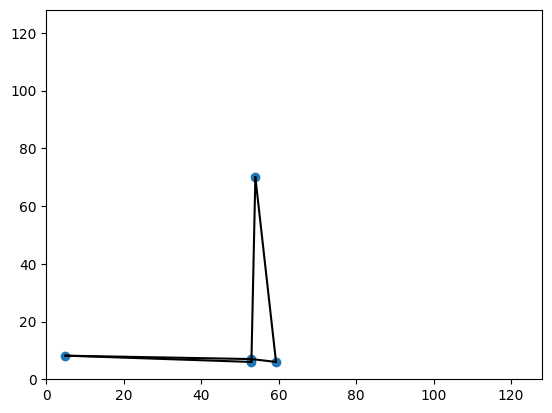

In [53]:
query, _ = sample_subgraph(graph)
fig, ax = plt.subplots(1, 1)
draw_graph(query.pos, query.edge_index.t(), ax)

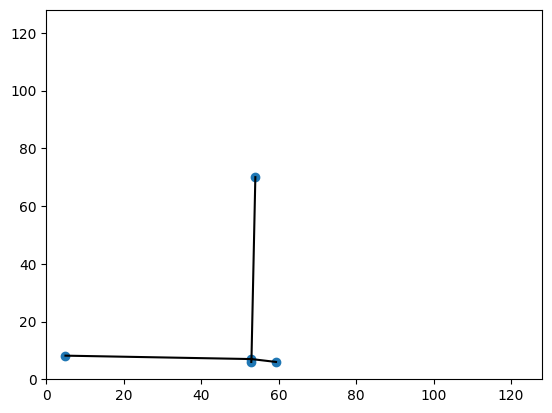

In [44]:
fig, ax = plt.subplots(1, 1)
draw_graph(graph.pos, graph.edge_index.t(), ax)

In [5]:
dataset = CitiesDataset()
file_path = '/media/data/anna_alex/greed/cities_50.pt'
generate(dataset, file_path, num_pairs=50)

shiftshiftshift
tensor([[ 0.0032,  0.0024],
        [-0.0051,  0.0185],
        [ 0.0098,  0.0042],
        [ 0.0197, -0.0080]])add edges

shifttensor([[-0.0019,  0.0155],
        [-0.0070,  0.0184],
        [ 0.0021, -0.0060],
        [ 0.0026, -0.0121],
        [ 0.0021, -0.0050],
        [ 0.0128, -0.0007]])shift
add edgesadd edgestensor([[-1.6841e-02,  8.0287e-05],
        [ 1.6052e-02, -1.1263e-02]])
tensor([[ 0.0051, -0.0181],
        [ 0.0049,  0.0140],
        [-0.0154, -0.0075],
        [ 0.0109, -0.0011]])


add edgesadd edges
add edges
add edges

tensor([[ 0.0199, -0.0002]])


add edges


add nodesadd edgesadd nodes


add nodes
add nodesadd nodesadd edgesadd edgesshiftshift




tensor([[ 0.0142,  0.0130],
        [ 0.0112,  0.0124],
        [-0.0038,  0.0061],
        [ 0.0100, -0.0128],
        [-0.0029, -0.0062]])add nodesadd nodes


add nodes
tensor([[-0.0018,  0.0080],
        [ 0.0086,  0.0125]])
add edges
shift
shiftshift
add edgesadd edges
add nodestensor([[ 3.7411e-0

TypeError: expected Tensor as element 0 in argument 0, but got list


add edges
add nodesadd edges




add nodes
tensor([[ 0.0116, -0.0127],
        [-0.0063, -0.0043],
        [-0.0061,  0.0188],
        [ 0.0133, -0.0106]])
add edges
